# Siamese Neural Network task

## Loading models

In [3]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

image_cnn = load_model("models/image_cnn.h5")
audio_cnn = load_model("models/audio_cnn.h5")

In [5]:
image_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,771 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [6]:
audio_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 15, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 5, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,043 (43.14 KB)

 Trainable params: 10,849 (42.38 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 2 (12.00 B)

## Extracting embeddings

In [23]:
# Output from the "dense" layer (output shape of 64)
image_embedding_model = Model(inputs=image_cnn.layers[0].input, outputs=image_cnn.get_layer("dense").output)
audio_embedding_model = Model(inputs=audio_cnn.layers[0].input, outputs=audio_cnn.get_layer("dense").output)

In [24]:
# Images
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

img_size = (128, 128)
batch_size = 32
data_dir = "data/images"

# Create a validation dataset (20% of the data)
val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Audios
from sklearn.model_selection import train_test_split

audio_data = np.load("data/audio/audio_features.npz")
X = audio_data['X']
y = audio_data['y']

# Assume X and y are the full audio feature arrays
X_train_audio, X_val_audio, y_train_audio, y_val_audio = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

Found 8000 files belonging to 2 classes.
Using 1600 files for validation.


In [25]:
image_embeddings = []
image_labels = []

for images, labels in val_ds:
    embeddings = image_embedding_model.predict(images)
    image_embeddings.append(embeddings)
    image_labels.append(labels.numpy())

# Concatenate all batches
image_embeddings = np.concatenate(image_embeddings, axis=0)
image_labels = np.concatenate(image_labels, axis=0)
print("Image embeddings shape:", image_embeddings.shape)

audio_embeddings = audio_embedding_model.predict(X_val_audio)
print("Audio embeddings shape:", audio_embeddings.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

2025-03-09 10:54:16.640722: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## PCA to visualize separation

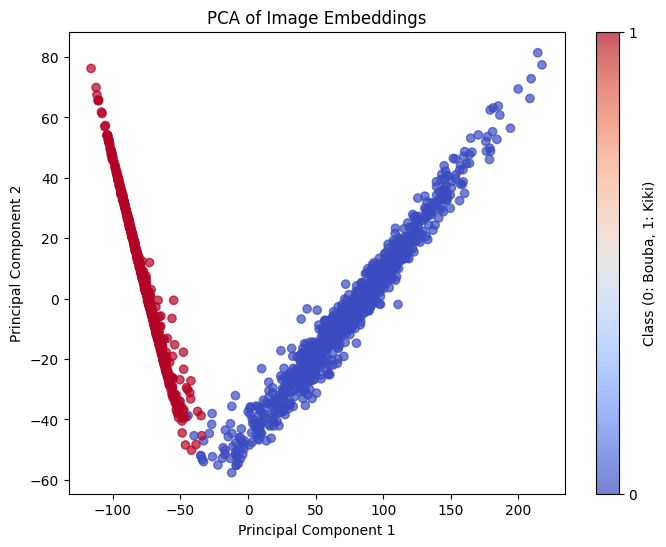

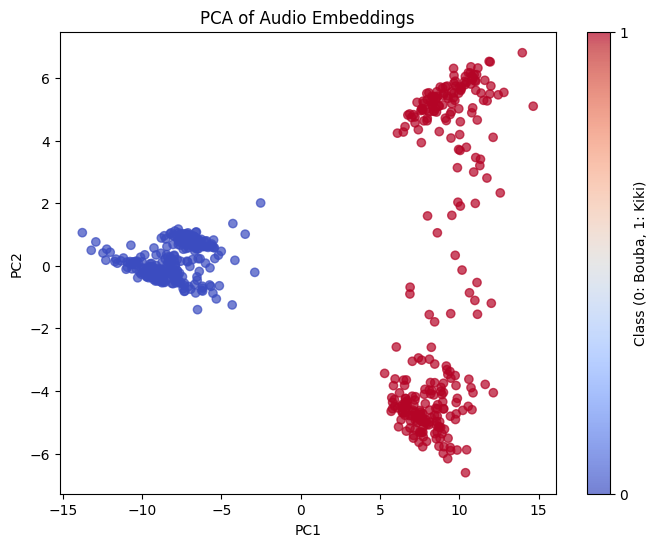

In [74]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- PCA for Image Embeddings ---
pca_image = PCA(n_components=2)
image_embeddings_pca = pca_image.fit_transform(image_embeddings)

plt.figure(figsize=(8,6))
scatter = plt.scatter(image_embeddings_pca[:, 0], image_embeddings_pca[:, 1], 
                      c=image_labels, cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter, ticks=[0, 1], label='Class (0: Bouba, 1: Kiki)')
plt.title("PCA of Image Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# --- PCA for Audio Embeddings ---
pca_audio = PCA(n_components=2)
audio_embeddings_pca = pca_audio.fit_transform(audio_embeddings)

audio_labels = y_val_audio
plt.figure(figsize=(8,6))
scatter = plt.scatter(audio_embeddings_pca[:, 0], audio_embeddings_pca[:, 1], 
                      c=audio_labels, cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter, ticks=[0, 1], label='Class (0: Bouba, 1: Kiki)')
plt.title("PCA of Audio Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


## Setup pairs for SNN

In [31]:
import numpy as np
import random

# Create dictionaries to get image embeddings by class
image_by_class = {}
for label in [0, 1]:
    indices = np.where(image_labels == label)[0]
    image_by_class[label] = image_embeddings[indices]

pair_audio = []
pair_image = []
pair_labels = []

# For each audio sample, create one positive and one negative pair
for i in range(len(audio_embeddings)):
    audio_embed = audio_embeddings[i]
    label = audio_labels[i]
    
    # Positive pair- randomly choose an image embedding from the same class
    pos_image = random.choice(image_by_class[label])
    pair_audio.append(audio_embed)
    pair_image.append(pos_image)
    pair_labels.append(1)
    
    # Negative pair- randomly choose an image embedding from the opposite class
    neg_label = 1 - label  # swap 0 and 1
    neg_image = random.choice(image_by_class[neg_label])
    pair_audio.append(audio_embed)
    pair_image.append(neg_image)
    pair_labels.append(0)

pair_audio = np.array(pair_audio)   # Expected shape: (1200, 64)
pair_image = np.array(pair_image)   # Expected shape: (1200, 128)
pair_labels = np.array(pair_labels)   # Expected shape: (1200,)

print("Pair audio shape:", pair_audio.shape)
print("Pair image shape:", pair_image.shape)
print("Pair labels shape:", pair_labels.shape)


Pair audio shape: (1200, 64)
Pair image shape: (1200, 128)
Pair labels shape: (1200,)


In [32]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model

input_audio = Input(shape=(64,), name='input_audio')
input_image = Input(shape=(128,), name='input_image')

# Project branches to 128-dim
proj_audio = Dense(128, activation='relu', name='proj_audio')(input_audio)
proj_image = Dense(128, activation='relu', name='proj_image')(input_image)

# Compute the euclidian distance between the two projections
l1_distance = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]), name='l1_distance')([proj_audio, proj_image])

fc = Dense(64, activation='relu', name='fc')(l1_distance)
output = Dense(1, activation='sigmoid', name='output')(fc)

siamese_model = Model(inputs=[input_audio, input_image], outputs=output)
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
siamese_model.summary()


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_audio         │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_image         │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ proj_audio (Dense)  │ (None, 128)       │      8,320 │ input_audio[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ proj_image (Dense)  │ (None, 128)       │     16,512 │ input_image[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_distance         │ (None, 128)       │          0 │ proj_audio[0][0], │
│ (Lambda)            │                   │            │ proj_image[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc (Dense)          │ (None, 64)        │      8,256 │ l1_distance[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ fc[0][0]          │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,153 (129.50 KB)

 Trainable params: 33,153 (129.50 KB)

 Non-trainable params: 0 (0.00 B)

## Training

In [33]:
epochs = 10
batch_size = 32

history_siamese = siamese_model.fit(
    [pair_audio, pair_image],
    pair_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    shuffle=True
)


Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5517 - loss: 3.1059 - val_accuracy: 0.9708 - val_loss: 0.1197
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.9960 - loss: 0.0458 - val_accuracy: 0.9958 - val_loss: 0.0235
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.9984 - loss: 0.0117 - val_accuracy: 0.9958 - val_loss: 0.0135
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.9958 - val_loss: 0.0102
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.9958 - val_loss: 0.0082
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9958 - val_loss: 0.0072
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9958 - val_loss: 0.0064
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.00

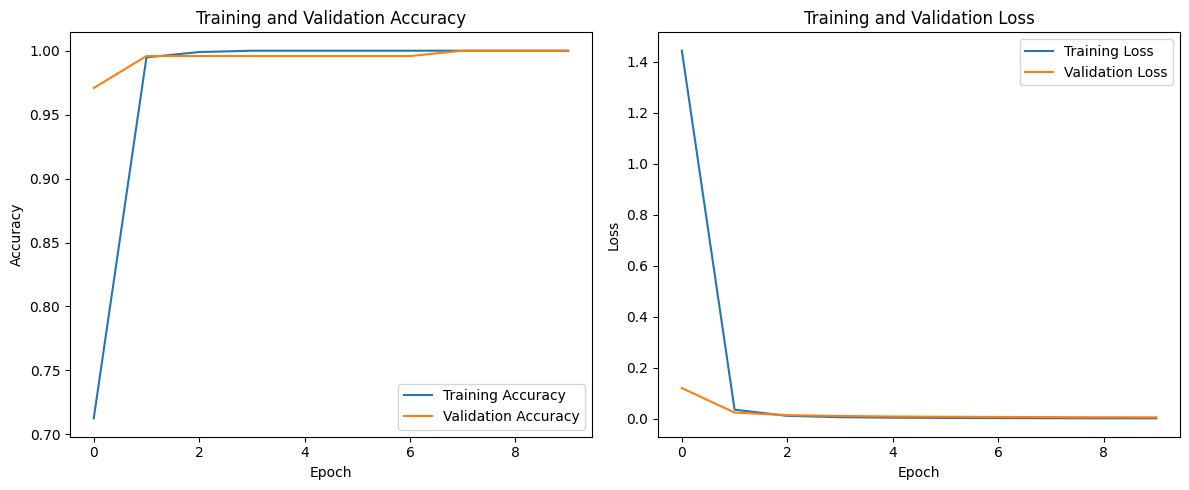

In [34]:
import matplotlib.pyplot as plt

acc = history_siamese.history['accuracy']
val_acc = history_siamese.history['val_accuracy']
loss = history_siamese.history['loss']
val_loss = history_siamese.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Accuracy plots
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plots
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


## Demonstration

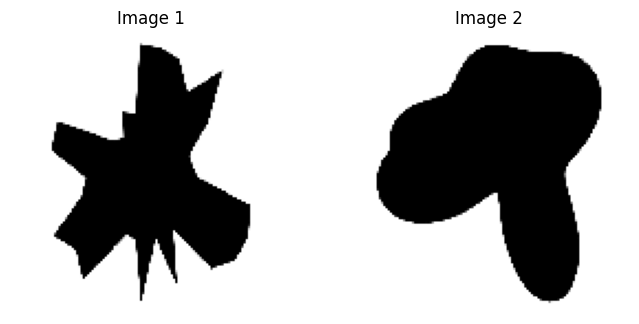

Playing audio...



(Correct answer: Image 2 )

Model reading...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Model prediction: Audio corresponds to Image 2 (Class: Bouba)
Result: Correct match!


In [86]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as keras_image
from IPython.display import Audio, display
import librosa
import time

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=22050)

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).mean(axis=1)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).mean()
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y).mean()

    return np.hstack([mfccs, spectral_centroid, spectral_bandwidth, spectral_rolloff, zero_crossing_rate])

# Directories
image_bouba_dir = "data/images/bouba/"
image_kiki_dir = "data/images/kiki/"
audio_bouba_dir = "data/audio/aug_audio/bouba/"
audio_kiki_dir = "data/audio/aug_audio/kiki/"

# Randomly pick one Bouba image and one Kiki image
bouba_images = [os.path.join(image_bouba_dir, fname) for fname in os.listdir(image_bouba_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
kiki_images = [os.path.join(image_kiki_dir, fname) for fname in os.listdir(image_kiki_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

selected_bouba_image = random.choice(bouba_images)
selected_kiki_image = random.choice(kiki_images)

# Create candidate list with tuple: (image_path, true_class)
# 0 for Bouba and 1 for Kiki
candidates = [(selected_bouba_image, 0), (selected_kiki_image, 1)]
random.shuffle(candidates)  # Shuffle the order

# Randomly pick an audio file from either bouba or kiki
if random.random() < 0.5:
    audio_files = [os.path.join(audio_bouba_dir, fname) for fname in os.listdir(audio_bouba_dir) if fname.lower().endswith(".wav")]
    selected_audio_file = random.choice(audio_files)
    audio_true_label = 0  # Bouba
else:
    audio_files = [os.path.join(audio_kiki_dir, fname) for fname in os.listdir(audio_kiki_dir) if fname.lower().endswith(".wav")]
    selected_audio_file = random.choice(audio_files)
    audio_true_label = 1  # Kiki

# Display the two candidate images labeled 1 and 2
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for idx, (img_path, _) in enumerate(candidates):
    img = keras_image.load_img(img_path, target_size=(128,128))
    axes[idx].imshow(img)
    axes[idx].set_title(f"Image {idx+1}")
    axes[idx].axis("off")
plt.show()

# Play the audio
print("Playing audio...")
display(Audio(selected_audio_file))
correct_idx = next(i for i, (_, label) in enumerate(candidates) if label == audio_true_label)
print("\n(Correct answer: Image", correct_idx + 1, ")\n")

# Process the audio sample: extract features and get its embedding
time.sleep(2)
print("Model reading...")
time.sleep(2)

audio_features = extract_features(selected_audio_file)
audio_features = audio_features.reshape(1, -1, 1)
audio_embedding_model.build(input_shape=(None, 17, 1))
audio_emb = audio_embedding_model(audio_features)

# Process each candidate image: load image and get its embedding
candidate_scores = []
for img_path, candidate_class in candidates:
    img = keras_image.load_img(img_path, target_size=(128,128))
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_emb = image_embedding_model.predict(img_array)
    
    # Use the Siamese model to get a match probability
    score = siamese_model.predict([audio_emb, img_emb])[0][0]
    candidate_scores.append(score)

# The model selects the candidate with the higher score
predicted_index = np.argmax(candidate_scores)
predicted_candidate = candidates[predicted_index]
predicted_class = predicted_candidate[1]  # 0 for Bouba, 1 for Kiki

# Display results
time.sleep(0.5)
print(f"Model prediction: Audio corresponds to Image {predicted_index+1} (Class: {'Bouba' if predicted_class==0 else 'Kiki'})")
if predicted_class == audio_true_label:
    print("Result: Correct match!")
else:
    print("Result: Incorrect match.")